In [1]:
%matplotlib notebook
import cntk
cntk.device.try_set_default_device(cntk.device.gpu(0))
import os
os.environ['KERAS_BACKEND'] = 'cntk'
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D,MaxPool2D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz
import seaborn as sns

from keras.layers.core import Lambda
from keras import backend as K    


def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)

    return BatchInd,NumBatches
    
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot(label_list):
    NumLabels = len(label_list)
    MaxLabel = max(label_list)
    one_hot_labels = np.zeros([NumLabels,MaxLabel+1],dtype=int)
    for i in range(NumLabels):
        one_hot_labels[i,label_list[i]-1] = 1
        
    return one_hot_labels

InitStr = 'cifar-10-python\cifar-10-batches-py\data_batch_'
File = InitStr + np.str(1)
Batch = unpickle(File)
FullInputs = Batch[b'data']
FullTargets = one_hot(Batch[b'labels'])


for i in  range(4):
    File = InitStr + np.str(i+2)
    Batch = unpickle(File)
    FullInputs = np.append(FullInputs,Batch[b'data'],axis=0)
    FullTargets = np.append(FullTargets,one_hot(Batch[b'labels']),axis=0)
    
Conv = 1
if Conv == 1:
    FullInputs = np.reshape(FullInputs,[FullInputs.shape[0],3,32,32]).transpose(0,2,3,1)
    
FullInputs = FullInputs.copy(order='C')

Using CNTK backend


In [2]:
Validation_Cutoff = 0.75

Validation_Cutoff = np.int(Validation_Cutoff*FullInputs.shape[0])
if Conv == 1:
    ValInputs = FullInputs[Validation_Cutoff:,:,:,:]
else:
    ValInputs = FullInputs[Validation_Cutoff:,:]
ValTargets = FullTargets[Validation_Cutoff:,:]

if Conv == 1:
    TrainInputs = FullInputs[0:Validation_Cutoff,:,:,:]
else:
    TrainInputs = FullInputs[0:Validation_Cutoff,:]

TrainTargets = FullTargets[0:Validation_Cutoff,:]

In [4]:
data_dim = TrainInputs.shape[1]
if Conv == 1:
    data_dim2 = TrainInputs.shape[2]
    NumChannels = 3
    
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0

def Gen_Conv_Model(reg_coeff):
    model = Sequential()
    model.add(Conv2D(10,(3,3),activation='relu',input_shape =(data_dim,data_dim2,NumChannels),data_format="channels_last"))
#     model.add(MaxPool2D())
#     model.add(BatchNormalization())
#     model.add(Conv2D(100,(3,3),activation='relu',data_format="channels_last"))
#     model.add(MaxPool2D())
#     model.add(BatchNormalization())
    model.add(Flatten())
#     model.add(Dropout(0.25))
    model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
#     model.add(Dropout(0.25))
#     model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.sgd(lr=0.00001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    
    return model

def Gen_FF_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(300,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(300,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(300,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.adagrad(lr=0.00001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    return model

if Conv == 1:
    ISHard_model = Gen_Conv_Model(reg_coeff)
    ISEasy_model = Gen_Conv_Model(reg_coeff)
#     DTHard_model = Gen_Conv_Model(reg_coeff)
#     DTEasy_model = Gen_Conv_Model(reg_coeff)
    Uni_model = Gen_Conv_Model(reg_coeff)
else:
    ISHard_model = Gen_FF_Model(reg_coeff)
    ISEasy_model = Gen_FF_Model(reg_coeff)
    DTHard_model = Gen_FF_Model(reg_coeff)
    DTEasy_model = Gen_FF_Model(reg_coeff)
    Uni_model = Gen_FF_Model(reg_coeff)

ISHard_model.set_weights(Uni_model.get_weights())
ISEasy_model.set_weights(Uni_model.get_weights())
# DTHard_model.set_weights(Uni_model.get_weights())
# DTEasy_model.set_weights(Uni_model.get_weights())

In [5]:
def acquisition_function_BALD(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
    
    MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

    NumPreds = 30
    MC_samples = np.zeros([NumPreds,samples.shape[0],Num_Targets])
    for i in range(NumPreds):
        MC_samples[i,:,:] = np.array(MC_output([samples,True]))

    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy
    
    Exp_BALD_acq = np.exp(BALD_acq/temperature)

    Sampling_Prob = Exp_BALD_acq/np.sum(Exp_BALD_acq).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_BALD_acq = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD_acq/np.sum(Exp_BALD_acq).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_BALD_acq = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD_acq/np.sum(Exp_BALD_acq).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
                
    return Sampling_Prob


def average_dist_to_threshold(model,samples,Num_Targets):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.mean(np.abs(Output),1)
    return Dist_to_Threshold

def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
    Exp_Dist_to_Threshold *= 1
#     Exp_Dist_to_Threshold = Dist_to_Threshold
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
            
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob



In [6]:
count = 0 
Num_Epochs = 256
Num_BurnIn = 1
Batch_Size = 256

Smoothing_Constant = 0

Val_Error = np.zeros([Num_Epochs,5])
Val_Acc = np.zeros([Num_Epochs,5])


<IPython.core.display.Javascript object>


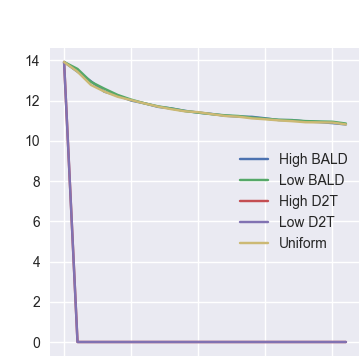

<IPython.core.display.Javascript object>


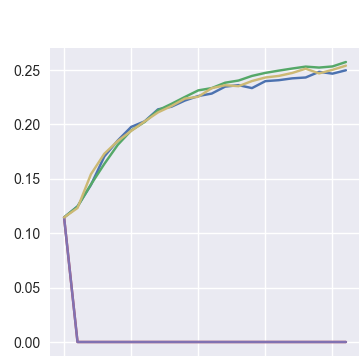

<IPython.core.display.Javascript object>


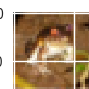

<IPython.core.display.Javascript object>


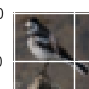

Epoch 1/1
37500/37500 [==============================] - 2s 64us/step - loss: 13.9623 - categorical_accuracy: 0.1137
0
10.209746
Epoch 1/1
 11/146 [=>............................] - ETA: 2s - loss: 13.8220 - categorical_accuracy: 0.1207

C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input577") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


146/146 [==============================] - 2s 14ms/step - loss: 13.5971 - categorical_accuracy: 0.1245
Epoch 1/1
 11/146 [=>............................] - ETA: 2s - loss: 13.5792 - categorical_accuracy: 0.1264

C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input745") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


146/146 [==============================] - 2s 14ms/step - loss: 13.5335 - categorical_accuracy: 0.1284
Epoch 1/1
 13/146 [=>............................] - ETA: 1s - loss: 13.8708 - categorical_accuracy: 0.1139

C:\Users\ian mcwilliam\AppData\Local\Continuum\Anaconda3\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input913") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


146/146 [==============================] - 2s 14ms/step - loss: 13.5743 - categorical_accuracy: 0.1251
1
10.211314
Epoch 1/1
146/146 [==============================] - 2s 14ms/step - loss: 13.0945 - categorical_accuracy: 0.1457
Epoch 1/1
146/146 [==============================] - 2s 14ms/step - loss: 13.0880 - categorical_accuracy: 0.1389
Epoch 1/1
146/146 [==============================] - 2s 14ms/step - loss: 13.0011 - categorical_accuracy: 0.1459
2
10.043588
Epoch 1/1
146/146 [==============================] - 2s 14ms/step - loss: 12.6194 - categorical_accuracy: 0.1660
Epoch 1/1
146/146 [==============================] - 2s 14ms/step - loss: 12.3293 - categorical_accuracy: 0.1705
Epoch 1/1
146/146 [==============================] - 2s 14ms/step - loss: 12.4597 - categorical_accuracy: 0.1750
3
10.136658
Epoch 1/1
146/146 [==============================] - 2s 14ms/step - loss: 12.2178 - categorical_accuracy: 0.1897
Epoch 1/1
146/146 [==============================] - 2s 14ms/step - lo

KeyboardInterrupt: 

In [7]:
fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

fig2 = plt.figure(figsize = [4,4])
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()

fig3 = plt.figure(figsize = [1,1])
ax3 = fig3.add_subplot(111)
plt.ion()
fig3.show()
fig3.canvas.draw()

fig4 = plt.figure(figsize = [1,1])
ax4 = fig4.add_subplot(111)
plt.ion()
fig4.show()
fig4.canvas.draw()

def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
#         Sampling_Probability = Sampling_Probability/Sampling_Probability.sum()
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
            
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
#         ISHard_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
#         Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[count,0] = Error[0]
#         Val_Acc[count,0] = Error[1]
        
#         ISEasy_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=0)
#         Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[count,1] = Error[0]
#         Val_Acc[count,1] = Error[1]

        Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=1)
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,:] = Error[0]
        Val_Acc[count,:] = Error[1]
        
        ISHard_model.set_weights(Uni_model.get_weights())
        ISEasy_model.set_weights(Uni_model.get_weights())
#         DTHard_model.set_weights(Uni_model.get_weights())
#         DTEasy_model.set_weights(Uni_model.get_weights())
        
        
        
    else:
        Hard_Sampling_Probability = acquisition_function_dist_to_threshold(ISHard_model,TrainInputs,Num_Targets,1,10)
        Easy_SamplingProbability = 1/acquisition_function_dist_to_threshold(ISEasy_model,TrainInputs,Num_Targets,1,10)
        Easy_SamplingProbability/= Easy_SamplingProbability.sum().astype(float)
        print(Hard_Sampling_Probability.max()/Hard_Sampling_Probability.min())
        
#         DTHard_Sampling_Probability = acquisition_function_dist_to_threshold(ISHard_model,TrainInputs,Num_Targets,1,10)
#         DTEasy_SamplingProbability = 1/acquisition_function_dist_to_threshold(ISEasy_model,TrainInputs,Num_Targets,1,10)
#         DTEasy_SamplingProbability/= DTEasy_SamplingProbability.sum().astype(float)
        
        MaxProbInd = Hard_Sampling_Probability.argmax()
        MinProbInd = Hard_Sampling_Probability.argmin()
        
        
        if Conv == 1:
            ax3.clear()
            ax3.imshow(TrainInputs[MaxProbInd,:,:,:].astype("uint8"))
            fig3.canvas.draw()
            ax4.clear()
            ax4.imshow(TrainInputs[MinProbInd,:,:,:].astype("uint8"))
            fig4.canvas.draw()
        else:
            ax3.clear()
            ax3.imshow(TrainInputs[MaxProbInd,:].reshape(3,32,32).transpose(1,2,0).astype("uint8"))
            fig3.canvas.draw()
            ax4.clear()
            ax4.imshow(TrainInputs[MinProbInd,:].reshape(3,32,32).transpose(1,2,0).astype("uint8"))
            fig4.canvas.draw()

        
        
        ISHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Hard_Sampling_Probability,0),
                                   steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)
        
        ISEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Easy_SamplingProbability,0),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)
        
#         DTHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,DTHard_Sampling_Probability,0),
#                                    steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)
        
#         DTEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,DTEasy_SamplingProbability,0),
#                                  steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)
        
        
        Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples)),
                                steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)
        
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
#         Error = DTHard_model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[count,2] = Error[0]
#         Val_Acc[count,2] = Error[1]
        
#         Error = DTEasy_model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[count,3] = Error[0]
#         Val_Acc[count,3] = Error[1]
        
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,4] = Error[0]
        Val_Acc[count,4] = Error[1]


    print(EpochLoop)
    
    ax.clear()
    ax.plot(Val_Error[0:count,0],label='High BALD')
    ax.plot(Val_Error[0:count,1],label='Low BALD')
    ax.plot(Val_Error[0:count,2],label='High D2T')
    ax.plot(Val_Error[0:count,3],label='Low D2T')
    ax.plot(Val_Error[0:count,4],label='Uniform')
    ax.legend(loc='best')
    fig.canvas.draw()
    
    ax2.clear()
    ax2.plot(Val_Acc[0:count,0],label='High BALD')
    ax2.plot(Val_Acc[0:count,1],label='Low BALD')
    ax2.plot(Val_Acc[0:count,2],label='High D2T')
    ax2.plot(Val_Acc[0:count,3],label='Low D2T')
    ax2.plot(Val_Acc[0:count,4],label='Uniform')
    fig2.canvas.draw()
    
    
    
    count += 1

In [12]:
 Uni_model.weights[0].value

array([[[[-0.08580774,  0.07054524,  0.0905385 , -0.04040952,
           0.1732864 ,  0.15565649, -0.11160469,  0.17981525,
          -0.14477295,  0.07045759],
         [ 0.20765632, -0.12173248,  0.00994921,  0.20446123,
           0.08609085, -0.03772093, -0.17875251, -0.00575677,
           0.15997088,  0.14076045],
         [-0.00254667,  0.14254934, -0.17758247, -0.19317839,
          -0.0946806 ,  0.14071731, -0.15473261, -0.08086564,
          -0.03401767, -0.20972893]],

        [[ 0.03789148, -0.14176136,  0.03576314, -0.1914103 ,
           0.19921918, -0.06837367,  0.18125239, -0.01684723,
           0.13053174, -0.21927069],
         [ 0.21180539,  0.13246177, -0.03206998, -0.05889118,
           0.15272282,  0.09032794,  0.06246214, -0.03253957,
           0.04141157, -0.21224892],
         [ 0.1646146 , -0.01625323, -0.16772771,  0.0318349 ,
           0.05889839, -0.13698532, -0.09551908, -0.03955542,
          -0.11971278, -0.05207603]],

        [[ 0.05697544,  0.0758

In [ ]:
def GPU_test_on_batch(mdl,Inputs,Targets,MaxNum = 12500):
    Error = []
    Acc = []
    Num

In [20]:
TrainInputs.shape[0]/4

9375.0

In [8]:
TestStr = 'cifar-10-python\cifar-10-batches-py\test_batch'

TestInputs = Batch[b'data']
TestTargets = one_hot(Batch[b'labels'])

if Conv == 1:
    TestInputs = np.reshape(TestInputs,[TestInputs.shape[0],3,32,32]).transpose(0,2,3,1)

In [9]:
TestError = np.zeros([5,2])
TestError[0,:] = ISHard_model.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = ISEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = DTHard_model.test_on_batch(TestInputs,TestTargets)
TestError[3,:] = DTEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[4,:] = Uni_model.test_on_batch(TestInputs,TestTargets)

TestError


array([[24.45214462,  0.1785    ],
       [24.59657288,  0.16869999],
       [24.52802277,  0.1745    ],
       [24.41062546,  0.17910001],
       [24.52110481,  0.17399999]])